In [1]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144793 sha256=b88b82bdad626e9f38ba20bf4a824819aef0d5fd281611c4d88295a49207b565
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [91]:
import numpy as np
import pandas as pd
from pandas.io.parsers import StringIO
from io import StringIO
from datetime import date

import Levenshtein as Leven
import random

import seaborn as sns

from google.colab import files

import warnings
warnings.filterwarnings("ignore")

In [112]:
#подгружаем чистые данные
data = pd.read_csv("cleaned_data.csv", sep=',')

In [ ]:
#Оформляем
data = data.drop(columns=['issuer_eng', 'num', 'Unnamed: 0', 'index'])
data['issuer_eng'] = data['new']
data = data.drop(columns=['new'])

In [130]:
data.head()

,index,dept_code,issue_date,issuer_eng
0,1,20003,2001-11-05,OUFMS
1,2,20003,2002-03-22,MVD PO RESPUBLIKE BASHKORTOSTAN
2,3,20003,2002-05-18,MVD PO RESPUBLIKE BASHKORTOSTAN
3,4,20003,2002-08-13,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...
4,5,20003,2003-07-17,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...


In [116]:
#Делим на тестовую и обучающую
np.random.seed()
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [117]:
list(train.columns.values)

['dept_code', 'cluster', 'issue_date', 'issuer_eng']

In [118]:
#Переводим issue_date в формат даты
train = train[['dept_code', 'issue_date', 'issuer_eng']].drop_duplicates()
test['issue_date']= pd.to_datetime(test['issue_date'])
train['issue_date']= pd.to_datetime(train['issue_date'])

test = test[['dept_code', 'issuer_eng', 'issue_date']]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20699 entries, 0 to 104348
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dept_code   20699 non-null  int64         
 1   issuer_eng  20699 non-null  object        
 2   issue_date  20699 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 646.8+ KB


In [119]:
#Соединяем по dept_code и ближайшей issue_date
test = pd.merge_asof(left=test.sort_values('issue_date'), right=train.sort_values('issue_date'), on = 'issue_date', by="dept_code", direction='nearest')

In [120]:
test.head()

,dept_code,issuer_eng_x,issue_date,issuer_eng_y
0,282002,UVD GOR. BLAGOVESCHENSKA,2001-02-05,UVD GOR. BLAGOVESCHENSKA
1,632033,AVTOZAVODSKIM RUVD G. TOL'JATTI SAMARSKOJ OBL.,2001-02-13,AVTOZAVODSKIM RUVD G. TOL'JATTI SAMARSKOJ OBL.
2,282002,UVD GOR. BLAGOVESCHENSKA,2001-02-13,UVD GOR. BLAGOVESCHENSKA
3,632033,AVTOZAVODSKIM RUVD G. TOL'JATTI SAMARSKOJ OBL.,2001-02-16,AVTOZAVODSKIM RUVD G. TOL'JATTI SAMARSKOJ OBL.
4,282002,UVD GOR. BLAGOVESCHENSKA,2001-02-20,UVD GOR. BLAGOVESCHENSKA


In [121]:
#Смотрим точность предсказания
test['accuracy'] = np.where(test['issuer_eng_x'] == test['issuer_eng_y'], True, False)
test[test['accuracy']==True].count()[0]/test.count()[0]

0.9849268080583603

In [122]:
#Рассчитываем расстояние Левенштейна между реальными и предсказанными значениями
test['levenshtein'] = 0
for ind in test.index: 
     test['levenshtein'][ind] = Leven.distance(test['issuer_eng_x'][ind], test['issuer_eng_y'][ind])

In [ ]:
test.to_csv('test_vlookup_cleaned.csv')
files.download('test_vlookup_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [123]:
print(test['levenshtein'].mean(), test['levenshtein'].median())

0.45857287791680756 0.0


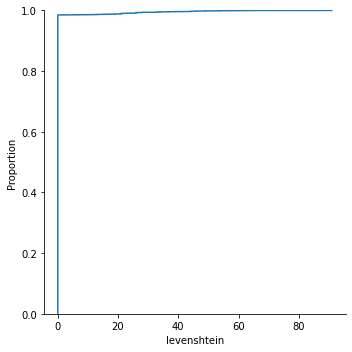

In [124]:
#График распределения расстояния Левенштейна с накоплением
sns.displot(test, x="levenshtein", kind="ecdf")

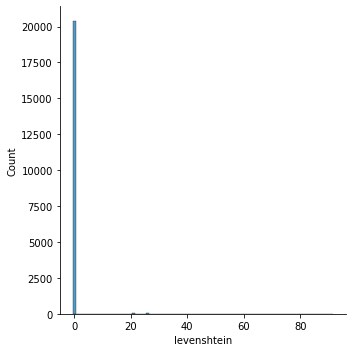

In [125]:
#Гистограмма распределения расстояния Левенштейна
g = sns.displot(test, x="levenshtein", discrete=True)

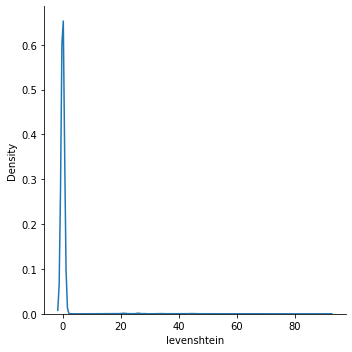

In [126]:
#График плотности распределения расстояния Левенштейна
g = sns.displot(test, x="levenshtein", kind = 'kde')

In [127]:
#Проверим качество кластеризации на тестовой выборке грязных данных

data = pd.read_csv("Data.csv", sep=',')
#удаляем неразделяемые строчки (85)
data['failed'] = data['dept_code'].str.contains(';', regex=True)
data = data[data['failed'] == False]
data['dept_code'] = data['dept_code'].astype('int64')

#удаляем наблюдения до 2001 года (ошибки, например, дата заполнения вместо даты рождения)
data['index'] = range(1, len(data) + 1)
data = data[['index', 'dept_code', 'issue_date', 'issuer_eng' ]]
data.groupby(['dept_code', 'issuer_eng']).agg(['count']).groupby(['dept_code']).agg(['count'])
data['issue_date']= pd.to_datetime(data['issue_date'])
data = data[data['issue_date'].dt.strftime('%Y') >= '2001']

#Делим на тестовую и обучающую
np.random.seed(15)
msk = np.random.rand(len(data)) < 0.8
train_raw = data[msk]
test_raw = data[~msk]


#Переводим issue_date в формат даты
test_raw['issue_date']= pd.to_datetime(test_raw['issue_date'])
test_raw = test_raw[['dept_code', 'issuer_eng', 'issue_date']]

#Соединяем по dept_code и ближайшей issue_date
test_raw = pd.merge_asof(left=test_raw.sort_values('issue_date'), right=train.sort_values('issue_date'), on = 'issue_date', by="dept_code", direction='nearest')

#Рассчитываем расстояние Левенштейна между реальными и предсказанными значениями
test_raw['levenshtein'] = 0
for ind in test_raw.index: 
     test_raw['levenshtein'][ind] = Leven.distance(test_raw['issuer_eng_x'][ind], test_raw['issuer_eng_y'][ind])

In [128]:
print(test_raw['levenshtein'].mean(), test_raw['levenshtein'].median())

4.019229837733107 0.0


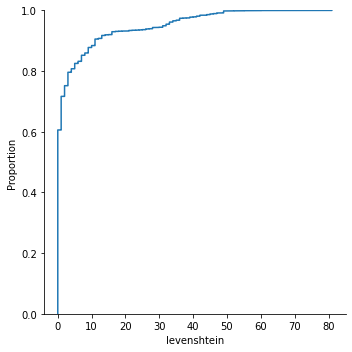

In [129]:
#График распределения расстояния Левенштейна с накоплением
sns.displot(test_raw, x="levenshtein", kind="ecdf")